# Grounded-SAM2
https://github.com/facebookresearch/sam2

## Example 1
Image prediction without using GroundingDino

### Set-up

In [57]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from pygments.formatters import img

In [6]:
# check current directory
os.chdir("/home/eiji/sam2/notebooks")
print(os.getcwd())

/home/eiji/sam2/notebooks


In [7]:
# Select the device for computation
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebookk
    torch.autocast('cuda', dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [8]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 14/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolors='white', linewidths=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolors='white', linewidths=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, ax=plt.gca())
        if box_coords is not None:
            #boxes
            show_box(box_coords, ax=plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

### Sample image

In [27]:
os.getcwd()

'/home/eiji/sam2/notebooks'

In [60]:
image = Image.open('images/truck.jpg')
image = np.array(image.convert('RGB'))

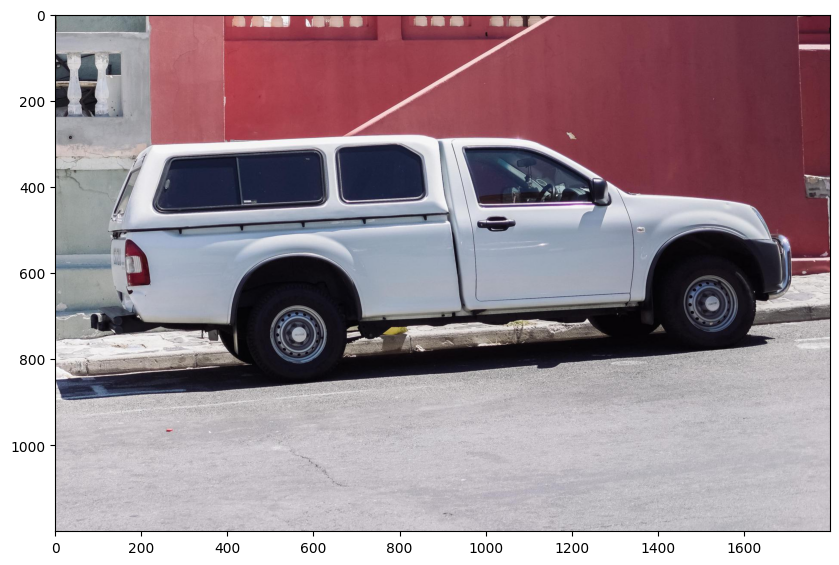

In [61]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

### Selecting objects with SAM 2
First, load the SAM 2 model and predictor. Change the path below to point to the SAM 2 checkpoint. Running on CUDA and using the default model are recommended for best results.

In [1]:
import sys
sys.path.insert(0, '/home/eiji/sam2')

In [2]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [11]:
sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)

Process the image to produce an <span style="color:red">image embedding</span> by calling SAM2ImagePredictor.set_image. SAM2ImagePredictor remembers this embedding and will use it for subsequent mask prediction.

In [12]:
predictor.set_image(image)

To select the truck, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

In [13]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

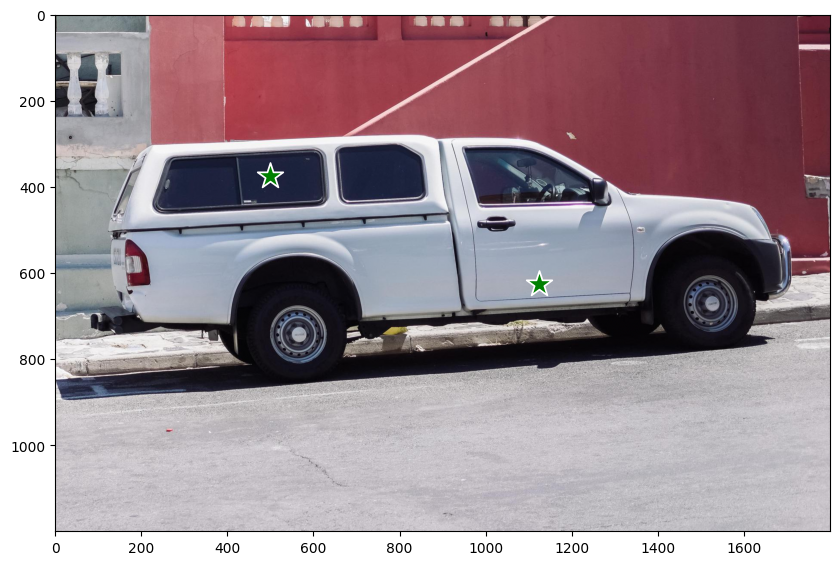

In [56]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, ax=plt.gca())
plt.axis('on')
plt.show()

In [15]:
print(predictor._features["image_embed"].shape, predictor._features["image_embed"][-1].shape)

torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])


Predict with <span style="color:red">SAM2ImagePredictor</span>.predict. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [16]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

With <span style="color:red">multimask_output=True</span> (the default setting), SAM 2 outputs 3 masks, where scores gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. <span style="color:red">When False, it will return a single mask</span>. For ambiguous prompts such as a single point, it is recommended to use multimask_output=True even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in scores. This will often result in a better mask.

(3, 1200, 1800)


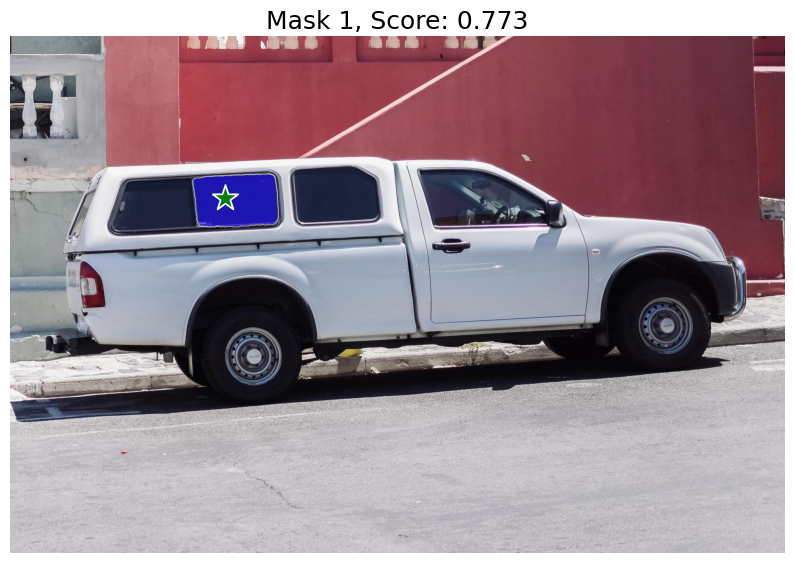

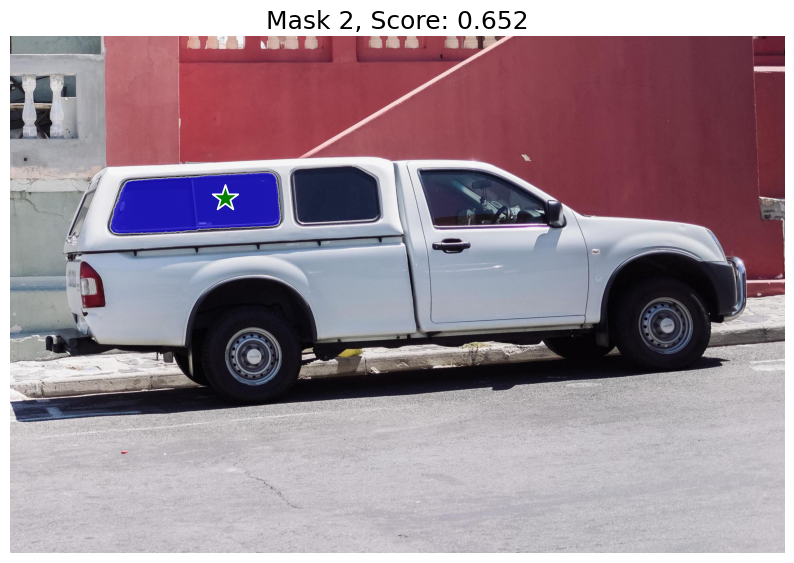

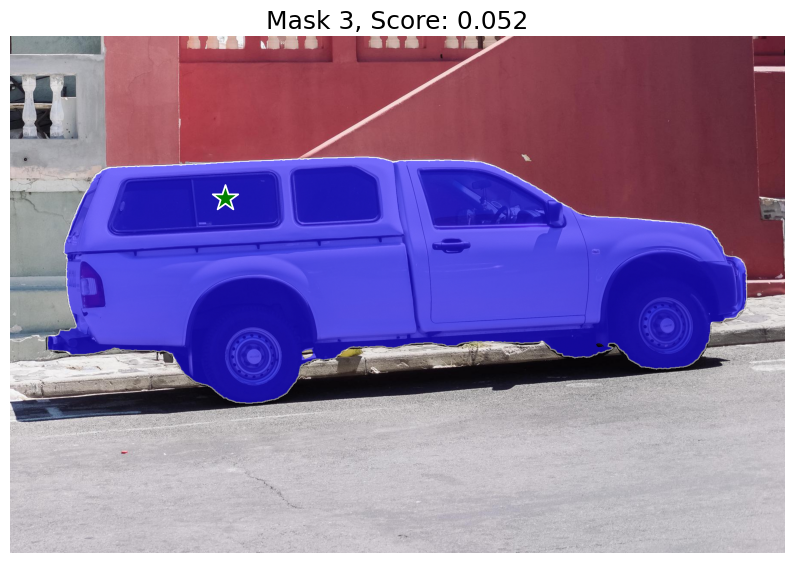

In [32]:
print(masks.shape)
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

### Specifying a specific object with additional points
The single input point is ambiguous, and the model has returned multiple objects consistent with it. To obtain a single object, multiple points can be provided. If available, a mask from a previous iteration can also be supplied to the model to aid in prediction. <span style="color:red">When specifying a single object with multiple prompts, a single mask can be requested by setting multimask_output=False</span>.

In [33]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 1])
mask_input = logits[np.argmax(scores), :, :]

In [53]:
masks, scores, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False
)

In [54]:
masks.shape

(1, 1200, 1800)

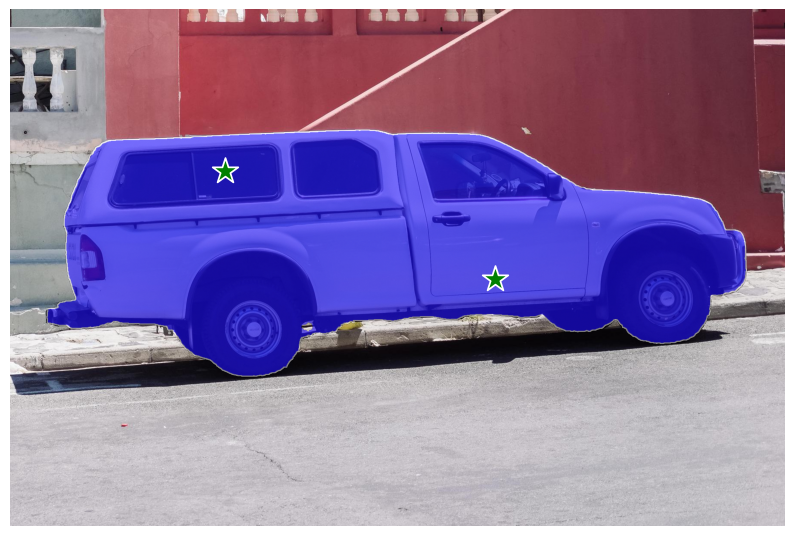

In [55]:
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label)

To exclude the car and specify just the window, a background point (with label 0, here shown in red) can be supplied.

In [62]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 0])
mask_input = logits[np.argmax(scores), :, :] # choose the model's best mask

In [63]:
masks, scores, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False
)

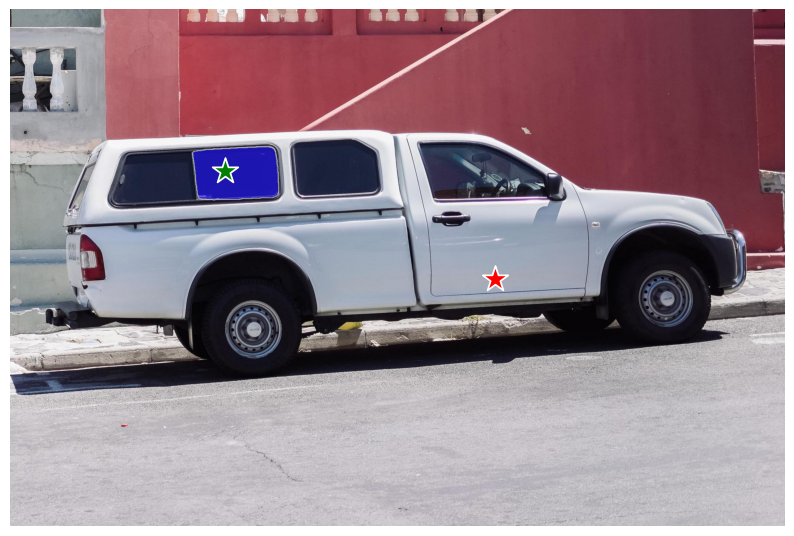

In [65]:
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label)

### Spcifying a specific object with a box

In [69]:
input_box = np.array([425, 600, 700, 875])


In [70]:
masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False
)

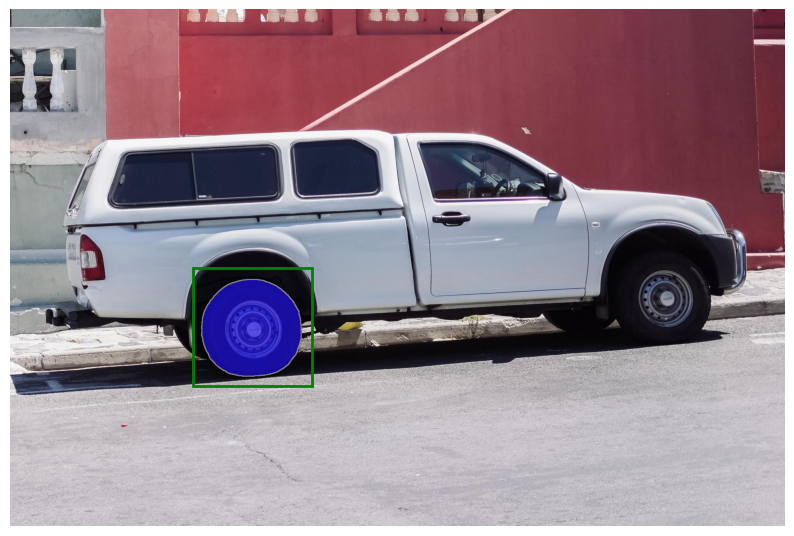

In [71]:
show_masks(image, masks, scores, box_coords=input_box)

### Combining points and boxes
Points and boxes may be combined, just by including both types of prompts to the predictor. Here this can be used to select just the trucks's tire, instead of the entire wheel.

In [73]:
input_box = np.array([425, 600, 700, 875])
input_point = np.array([[575, 750]])
input_label = np.array([0])

In [74]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

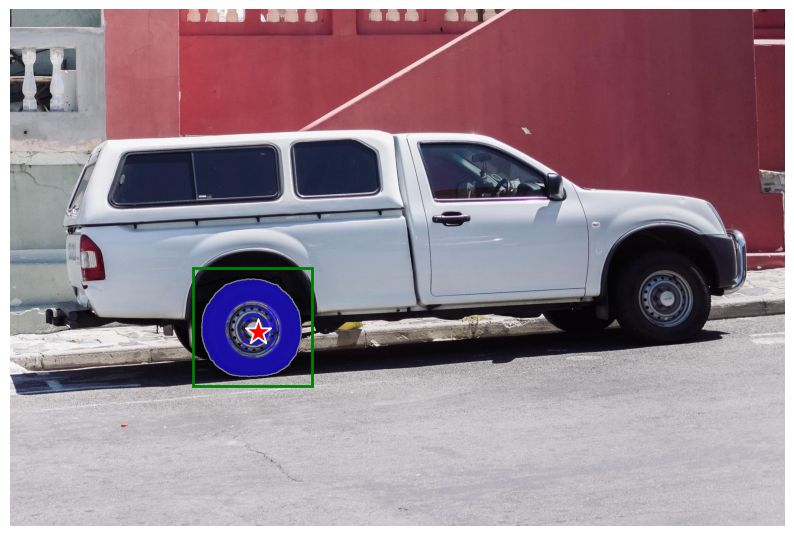

In [75]:
show_masks(image, masks, scores, box_coords=input_box, point_coords=input_point, input_labels=input_label)

### Batched prompt inputs
<span style="color:red">SAM2ImagePredictor</span> can take multiple input prompts for the same image, using predict method. For example, imagine we have several box outputs from an object detector.

In [76]:
input_boxes = np.array([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
])

In [77]:
masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    multimask_output=False,
)

In [78]:
masks.shape

(4, 1, 1200, 1800)

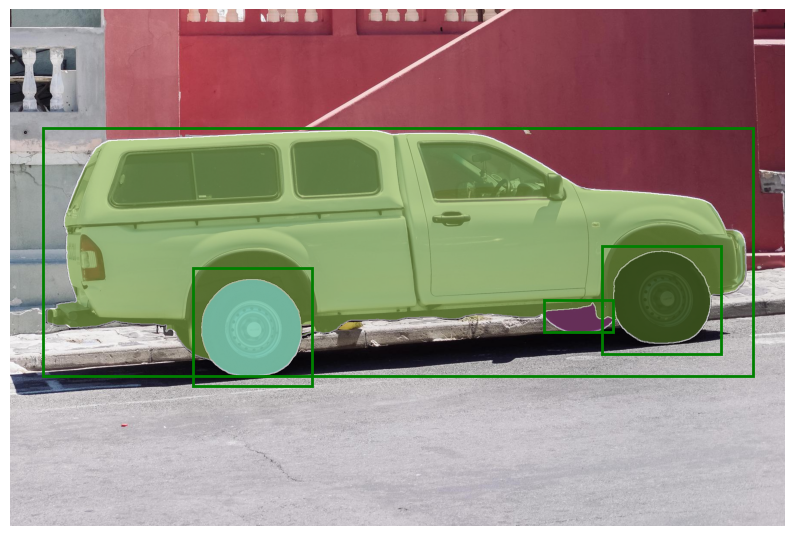

In [88]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.squeeze(0), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box, plt.gca())
plt.axis('off')
plt.show()

In [84]:
masks[0].squeeze(0).shape

(1200, 1800)

### End-to-end batched inference
If all prompts are available in advance, it is possible to run SAM 2 directly in an end-to-end fashion. This also allows batching over images.

In [89]:
image1 = image
image1_boxes = np.array([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
])

image2 = Image.open('images/groceries.jpg')
image2 = np.array(image2.convert('RGB'))
image2_boxes = np.array([
    [450, 170, 520, 350],
    [350, 190, 450, 350],
    [500, 170, 580, 350],
    [580, 170, 640, 350],
])

img_batch = [image1, image2]
boxes_batch = [image1_boxes, image2_boxes]

In [90]:
predictor.set_image_batch(img_batch)

/home/eiji/anaconda3/envs/ground-sam2/lib/python3.12/site-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


In [93]:
masks_batch, scores_batch, _ = predictor.predict_batch(
    None,
    None,
    box_batch=boxes_batch,
    multimask_output=False,
)

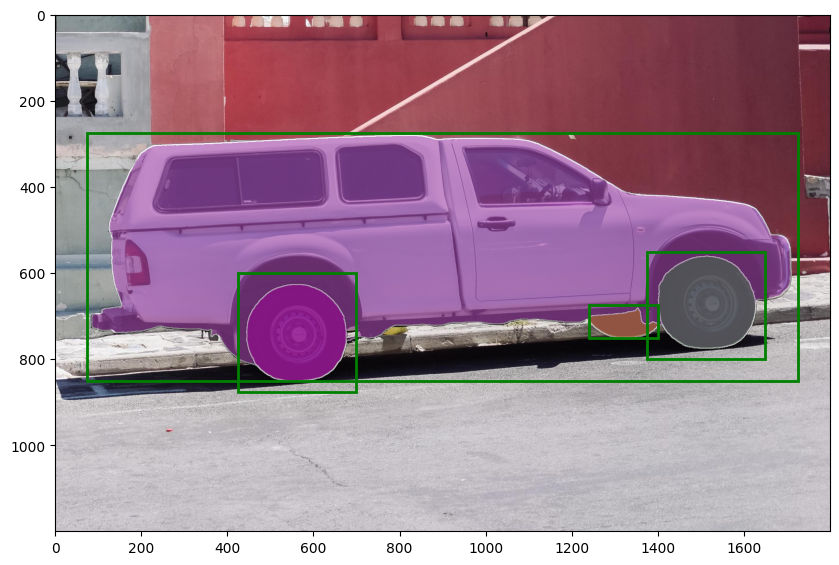

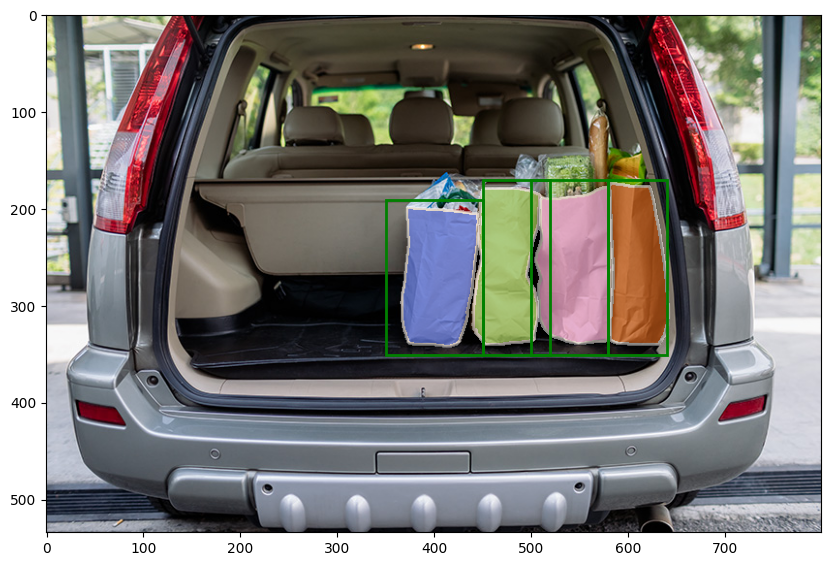

In [94]:
for image, boxes, masks in zip(img_batch, boxes_batch, masks_batch):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for mask in masks:
        show_mask(mask.squeeze(0), plt.gca(), random_color=True)
    for box in boxes:
        show_box(box, plt.gca())

#### Similary, we can haae a batch of point prompts defined over a batch of images

In [96]:
image = image
image1_pts = np.array([
    [[500, 375]],
    [[650, 750]]
])

image2_pts = np.array([
    [[400, 300]],
    [[630, 300]],
])
image2_labels = np.array([[1], [1]])

image1_labels = np.array([[1], [1]])
pts_batch = [image1_pts, image2_pts]
labels_batch = [image1_labels, image2_labels]

In [99]:
masks_batch, scores_batch, _ = predictor.predict_batch(pts_batch, labels_batch, box_batch=None, multimask_output=True)
best_masks = []
for masks, scores in zip(masks_batch, scores_batch):
    best_masks.append(masks[range(len(masks)), np.argmax(scores, axis=1)])

In [100]:
best_masks

[array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],
       shape=(2, 1200, 1800), dtype=float32),
 array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [

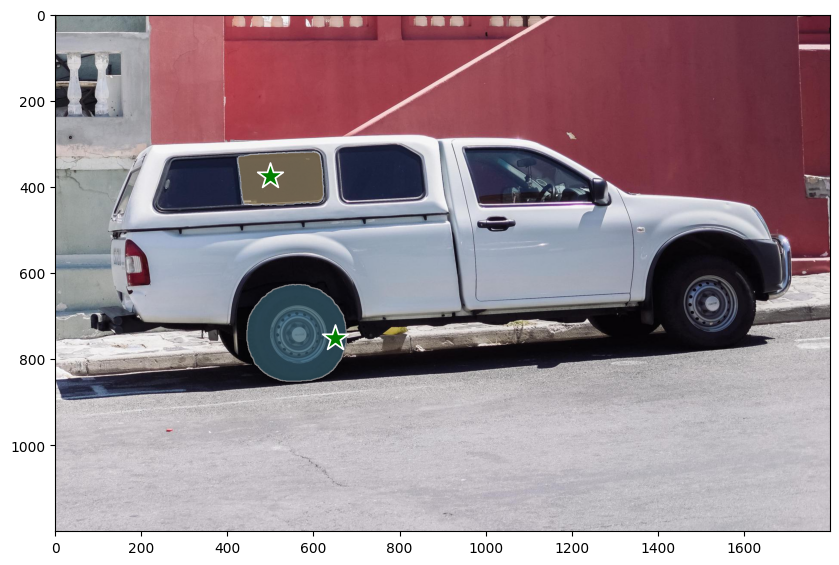

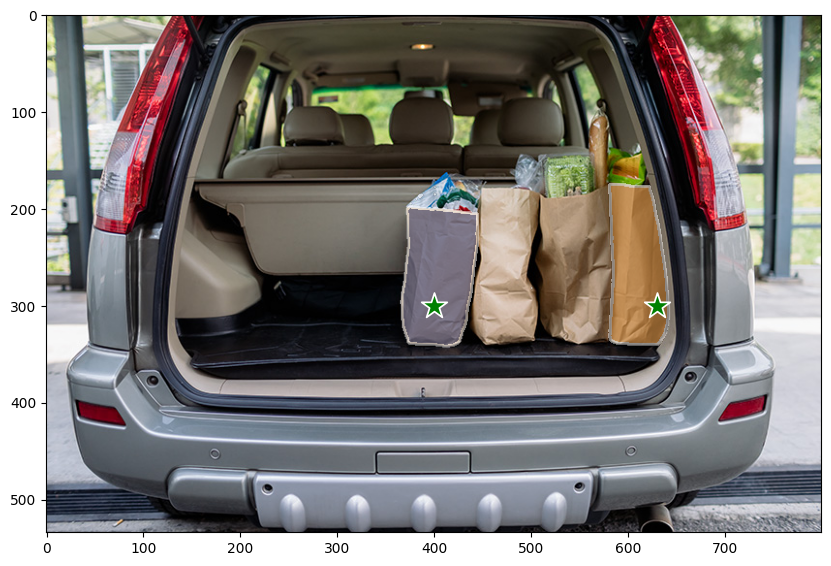

In [101]:
for image, points, labels, masks in zip(img_batch, pts_batch, labels_batch, best_masks):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for mask in masks:
        show_mask(mask, plt.gca(), random_color=True)
    show_points(points, labels, plt.gca())

## Example 2

In [3]:
import os
# from tensorflow import keras
import matplotlib.pyplot as plt
# If you have multiple GPUs, you can set the GPU to use here.
# The default is to use the first GPU, which is usually GPU 0.

import cv2
import numpy as np
import supervision as sv
from PIL import Image

import torch
import torchvision

from groundingdino.util.inference import Model
from groundingdino.util.inference import load_model, load_image, predict, annotate

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [5]:
# check current directory
os.chdir("/home/eiji/sam2/notebooks")
print(os.getcwd())

/home/eiji/sam2/notebooks


In [6]:
# Select the device for computation
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebookk
    torch.autocast('cuda', dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [7]:
# Define file names and model names
home_dir = "/home/eiji"
output_dir_name = "Output_sample"
checkpoint_path = "groundingdino_swint_ogc.pth"
config_path = "GroundingDINO_SwinT_OGC.py"

# Create a new directory
cd = os.getcwd()
print(cd)

output_dir = os.path.join(cd, output_dir_name)

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

/home/eiji/sam2/notebooks


In [10]:
annotated_file_name = "groundingdino_image.jpg"
annotated_seg_file_name = "grounded_SAM2_image.jpg"
checkpoint_path = os.path.join(home_dir, "Grounded-Segment-Anything", "groundingdino_swint_ogc.pth")
config_path = os.path.join(home_dir, "Grounded-Segment-Anything","GroundingDINO_SwinT_OGC.py")

In [9]:
# Building GroundingDINO inference model
grounding_dino_model = Model(model_config_path=config_path, model_checkpoint_path=checkpoint_path)

# Segment-Anything checkpoint
sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
sam2_predictor = SAM2ImagePredictor(sam2_model)

/home/eiji/anaconda3/envs/ground-sam2/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1739474893324/work/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


In [30]:
# Predict captions and hyper-param for GroundingDINO
# Input image
input_img_dir = os.path.join(home_dir, "Grounded-Segment-Anything", "assets")
IMAGE_PATH = os.path.join(input_img_dir, "demo9.jpg")
TEXT_PROMPT = "armchair. blanket. lamp. carpet. couch. dog. picture frame. pillow. plant. sit. stool. wood floor." ## for multiple prompts: "bear. water. grass."
BOX_THRESHOLD = 0.25
TEXT_THRESHOLD = 0.25
NMS_THRESHOLD = 0.8

# load image
image = cv2.imread(IMAGE_PATH)
image_source, image2 = load_image(IMAGE_PATH)

# detect objects
detections = grounding_dino_model.predict_with_caption(
    image= image,#cv2.cvtColor(image, cv2.COLOR_BGR2RGB), # new version of maybe just cv2.imread(IMAGE_PATH)
    caption=TEXT_PROMPT,
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD
)

boxes = torch.from_numpy(detections[0].xyxy)
confidence = detections[0].confidence
phrases = detections[-1]

# labels
labels = [f"{name} {conf:.2f}" for name, conf in zip(phrases, confidence)]

box_annotator = sv.BoxAnnotator()
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections[0], labels=labels)

# save the annotated grounding dino image
cv2.imwrite(os.path.join(output_dir, annotated_file_name), annotated_frame)

True

In [31]:
# Prompting SAM with detected boxes
def segment(sam2_predictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam2_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam2_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

In [32]:
# convert detections to masks
detections[0].mask = segment(
    sam2_predictor=sam2_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections[0].xyxy # when using predict_captions
)

# annotate image with detections
transparent_bbox_line = sv.Color(r=0, g=0, b=0)
box_annotator = sv.BoxAnnotator(thickness=0)
mask_annotator = sv.MaskAnnotator()

labels = [f"{name} {conf:.2f}" for name, conf in zip(detections[-1], confidence)]

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections[0])
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections[0], labels=labels)

# save the annotated grounded-sam image
cv2.imwrite(os.path.join(output_dir, annotated_seg_file_name), annotated_image) # only SAM with no bbox

True

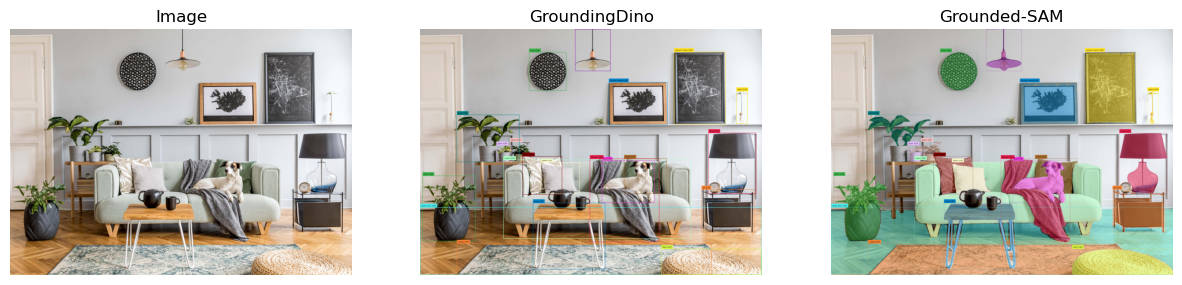

In [33]:
# Visualize all
image_bbox = Image.open(os.path.join(output_dir, annotated_file_name))
image_bbox = np.array(image_bbox.convert('RGB'))

image_sam2 = Image.open(os.path.join(output_dir, annotated_seg_file_name))
image_sam2 = np.array(image_sam2.convert('RGB'))

image_raw = Image.open(IMAGE_PATH)
image_raw = np.array(image_raw.convert('RGB'))

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15, 15))

# Original image
ax[0].imshow(image_raw / 255.0)
ax[0].set_title("Image")
ax[0].axis("off")

# GroundingDino (bbox)
ax[1].imshow(image_bbox / 255.0)
ax[1].set_title("GroundingDino")
ax[1].axis("off")

# Grounded-SAM
ax[2].imshow(image_sam2 / 255.0)
ax[2].set_title("Grounded-SAM")
ax[2].axis("off")

plt.show()